# Exercise 11

## Car Price Prediction

Predict if the price of a car is low or high

In [1]:
%matplotlib inline
import pandas as pd

data = pd.read_csv('https://github.com/albahnsen/PracticalMachineLearningClass/raw/master/datasets/dataTrain_carListings.zip')
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data['HighPrice'] = (data['Price'] > data['Price'].mean()).astype(int)
data = data.drop(['Model', 'Price'], axis=1)

data.head()

,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE,HighPrice
15,2016,29242,0,0,0,0,1,0,0,1
47,2015,26465,0,0,0,0,1,0,0,1
85,2012,46739,0,1,0,0,0,0,0,1
141,2017,41722,0,0,0,0,0,1,0,1
226,2014,77669,0,0,0,0,0,0,1,0


In [3]:
data.shape

(13150, 10)

In [4]:
y = data['HighPrice']
X = data.drop(['HighPrice'], axis=1)

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


In [6]:
import numpy as np

# Exercise 11.1

Estimate a Decision Tree Classifier Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

In [7]:
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

In [8]:
def gini_impurity(X_col, y, split):
    "Calculate the gain of an split k on feature j"
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_

In [9]:
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # For all features
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # For all splits
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [10]:
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calculate the best split
    j, split, gain = best_split(X, y, num_pct)
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=-1)
    
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]
    tree['gain'] = gain

    # Next iteration to each split
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [11]:
#Entrenamiento del arbol
tree=tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=6, num_pct=10)

In [12]:
def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Check if final node
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # If left node is empty only continue with right
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  # If right node is empty only continue with left
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted    

In [13]:
#Test del arbol
y_pred=tree_predict(X_test, tree)

In [14]:
from sklearn import metrics
print("Accuracy: ",metrics.accuracy_score(y_pred,y_test))

Accuracy:  0.8771889400921659


# Exercise 11.2

Estimate a Bagging of 10 Decision Tree Classifiers Manually using the code created in the Notebook #13

Evaluate the accuracy on the testing set

In [15]:
# set a seed for reproducibility
np.random.seed(123)
n_samples = X_train.shape[0]
n_B = 10
# create ten bootstrap samples (will be used to select rows from the DataFrame)
samples1 = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]

In [16]:
y_pred1 = pd.DataFrame(columns=["Sample","Accuracy"])
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_B)))
trees = {}

In [17]:
for i, sample in enumerate(samples1):
    X_train1 = X_train.iloc[sample]
    y_train1 = y_train.iloc[sample]
    trees[i] = tree_grow(X_train1, y_train1, level=0, min_gain=0.001, max_depth=5, num_pct=10)
    y_pred_df.iloc[:, i] =tree_predict(X_test, trees[i])
    y_pred1.at[i,"Sample"]=i
    y_pred1.at[i,"Accuracy"]=metrics.accuracy_score(y_pred_df.iloc[:, i], y_test)

In [18]:
y_pred_df.astype(int).head()

,0,1,2,3,4,5,6,7,8,9
332784,0,0,1,0,1,1,0,1,0,1
146436,1,1,1,1,1,1,1,1,1,1
130476,1,1,1,1,1,1,1,1,1,1
85618,1,1,1,1,1,1,1,1,1,1
75474,0,0,0,0,0,0,0,0,0,0


In [19]:
y_pred1

,Sample,Accuracy
0,0,0.871889
1,1,0.878802
2,2,0.878802
3,3,0.872811
4,4,0.875806
5,5,0.873272
6,6,0.873041
7,7,0.875115
8,8,0.878341
9,9,0.87788


In [20]:
y_pred1["Accuracy"].mean()

0.8755760368663594

In [21]:
y_pred = (y_pred_df.sum(axis=1) >= (n_B / 2)).astype(np.int)
print("Accuracy Bagging 10 samples:",metrics.accuracy_score(y_pred, y_test))

Accuracy Bagging 10 samples: 0.878110599078341


In [22]:
df = pd.DataFrame([key for key in trees.keys()], columns=['Arbol'])
df['y_pred'] = [value['y_pred'] for value in trees.values()]
df['y_prob'] = [value['y_prob'] for value in trees.values()]
df['split'] = [value['split'] for value in trees.values()]
df['n_samples'] = [value['n_samples'] for value in trees.values()]
df['gain'] = [value['gain'] for value in trees.values()]
print("First split by tree")
df

First split by tree


,Arbol,y_pred,y_prob,split,n_samples,gain
0,0,1,0.579551,"[1, 51677.09090909091]",8810,0.240265
1,1,1,0.578643,"[1, 52166.90909090909]",8810,0.235413
2,2,1,0.579891,"[1, 52110.545454545456]",8810,0.239641
3,3,1,0.570926,"[1, 53728.00000000001]",8810,0.230027
4,4,1,0.580232,"[1, 51453.81818181819]",8810,0.242949
5,5,1,0.580458,"[1, 52098.90909090909]",8810,0.248816
6,6,1,0.582842,"[1, 51251.54545454547]",8810,0.233944
7,7,1,0.576487,"[1, 52725.0]",8810,0.234950
8,8,1,0.575238,"[0, 2014.0]",8810,0.231734
9,9,1,0.581593,"[1, 51690.63636363637]",8810,0.235884


# Exercise 11.3

Implement the variable max_features on the Decision Tree Classifier created in 11.1.

Compare the impact in the results by varing the parameter max_features

Evaluate the accuracy on the testing set

In [23]:
def best_split(X, y, max_features=None,num_pct=10):
    
    #Max features part
    if max_features is None:
        features = range(X.shape[1])
    else:
        columnas_iniciales=range(X.shape[1])
        features = np.random.choice(a=columnas_iniciales, size=max_features, replace=False)
    #End
    
    
    best_split = [0, 0, 0]  # j, split, gain
    
    # For all features
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # For all splits
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)
                        
            if gain > best_split[2]:
                best_split = [j, split, gain]
    
    return best_split

In [24]:
def tree_grow(X, y, max_features=None,level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    #Max features part
    columnas_iniciales=range(X.shape[1])
    features = np.random.choice(a=columnas_iniciales, size=max_features, replace=False)
    #End
    
    # If only one observation
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calculate the best split
    j, split, gain = best_split(X, y,max_features, num_pct)
    
    # save tree and estimate prediction
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Laplace correction
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=-1)
    
    # Check stooping criteria
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # No stooping criteria was meet, then continue to create the partition
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]
    tree['gain'] = gain

    # Next iteration to each split
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

In [25]:
tree=tree_grow(X_train, y_train, max_features=6,level=0, min_gain=0.001, max_depth=3, num_pct=10)

In [26]:
y_pred=tree_predict(X_test, tree)

In [27]:
from sklearn import metrics
print("Accuracy: ",metrics.accuracy_score(y_pred,y_test))

Accuracy:  0.8407834101382489


In [28]:
max_feature = range(X_train.shape[1]+1)

results = []

for column in max_feature:
    tree = tree_grow(X_train, y_train, max_depth=6, max_features=column)
    y_pred = tree_predict(X_test, tree)
    results.append(metrics.accuracy_score(y_test, y_pred))

In [29]:
import matplotlib.pyplot as plt

(0.8615207373271889, 9)


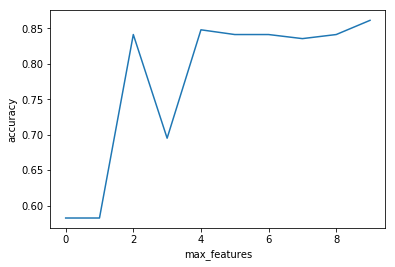

In [30]:
plt.plot(max_feature,results)
plt.xlabel('max_features')
plt.ylabel('accuracy')
print(sorted(zip(results,max_feature))[::-1][0])

# Exercise 11.4

Estimate a Bagging of 10 Decision Tree Classifiers with `max_features = log(n_features)`

Evaluate the accuracy on the testing set

In [31]:
from math import log
a=int(round(log(X_train.shape[1]),0))
a

2

In [32]:
# set a seed for reproducibility
np.random.seed(123)
n_samples = X_train.shape[0]
n_B = 10
# create ten bootstrap samples (will be used to select rows from the DataFrame)
samples1 = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]

In [33]:
y_pred1 = pd.DataFrame(columns=["Sample","Accuracy"])
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_B)))
trees = {}

In [34]:
for i, sample in enumerate(samples1):
    X_train1 = X_train.iloc[sample]
    y_train1 = y_train.iloc[sample]
    trees[i] = tree_grow(X_train1, y_train1, max_features=a,level=0, min_gain=0.001, max_depth=5, num_pct=10)
    y_pred_df.iloc[:, i] =tree_predict(X_test, trees[i])
    y_pred1.at[i,"Sample"]=i
    y_pred1.at[i,"Accuracy"]=metrics.accuracy_score(y_pred_df.iloc[:, i], y_test)

In [35]:
y_pred1

,Sample,Accuracy
0,0,0.813134
1,1,0.582488
2,2,0.841244
3,3,0.728341
4,4,0.810829
5,5,0.841475
6,6,0.836406
7,7,0.828802
8,8,0.840783
9,9,0.582488


In [36]:
y_pred1["Accuracy"].mean()

0.7705990783410138

In [37]:
y_pred = (y_pred_df.sum(axis=1) >= (n_B / 2)).astype(np.int)
print("Accuracy Bagging 10 samples:",metrics.accuracy_score(y_pred, y_test))

Accuracy Bagging 10 samples: 0.7993087557603686


In [38]:
df = pd.DataFrame([key for key in trees.keys()], columns=['Arbol'])
df['y_pred'] = [value['y_pred'] for value in trees.values()]
df['y_prob'] = [value['y_prob'] for value in trees.values()]
df['split'] = [value['split'] for value in trees.values()]
df['n_samples'] = [value['n_samples'] for value in trees.values()]
df['gain'] = [value['gain'] for value in trees.values()]
print("First split by tree")
df

First split by tree


,Arbol,y_pred,y_prob,split,n_samples,gain
0,0,1,0.579551,"[7, 1.0]",8810,0.047244
1,1,1,0.578643,"[8, 1.0]",8810,0.009034
2,2,1,0.579891,"[1, 52110.545454545456]",8810,0.239641
3,3,1,0.570926,"[3, 1.0]",8810,0.109324
4,4,1,0.580232,"[7, 1.0]",8810,0.045235
5,5,1,0.580458,"[1, 52098.90909090909]",8810,0.248816
6,6,1,0.582842,"[3, 1.0]",8810,0.112222
7,7,1,0.576487,"[8, 1.0]",8810,0.009225
8,8,1,0.575238,"[1, 52700.18181818182]",8810,0.231572
9,9,1,0.581593,"[8, 1.0]",8810,0.007771


# Exercise 11.5

Using sklearn, train a RandomForestClassifier

Evaluate the accuracy on the testing set

In [39]:
feature_cols = data.columns.drop('HighPrice')

In [40]:
from sklearn.ensemble import RandomForestClassifier

In [41]:
clf = RandomForestClassifier(random_state=1, n_jobs=-1)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [42]:
# compute feature importances
pd.DataFrame({'feature':feature_cols, 'importance':clf.feature_importances_}).sort_values('importance')

,feature,importance
4,M_CamryBase,0.000248
5,M_CamryL,0.004511
2,M_Camry,0.006028
8,M_CamryXLE,0.008000
6,M_CamryLE,0.008341
7,M_CamrySE,0.021857
3,M_Camry4dr,0.061144
0,Year,0.228017
1,Mileage,0.661854


In [43]:
y_pred_rf = clf.predict(X_test)
y_pred_rf

array([0, 1, 1, ..., 1, 1, 0])

In [44]:
print("Accuracy RF:",metrics.accuracy_score(y_pred_rf, y_test))

Accuracy RF: 0.83963133640553


In [45]:
#Ahora bagging 10 trees random forest
np.random.seed(123)
n_samples = X_train.shape[0]
n_B = 10
# create ten bootstrap samples (will be used to select rows from the DataFrame)
samples1 = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]

In [46]:
y_pred1 = pd.DataFrame(columns=["Sample","Accuracy"])
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_B)))

In [47]:
for i, sample in enumerate(samples1):
    X_train1 = X_train.iloc[sample]
    y_train1 = y_train.iloc[sample]
    clf.fit(X_train1, y_train1)
    y_pred_df.iloc[:, i] =clf.predict(X_test)
    y_pred1.at[i,"Sample"]=i
    y_pred1.at[i,"Accuracy"]=metrics.accuracy_score(y_pred_df.iloc[:, i], y_test)

In [48]:
y_pred_df.astype(int).head()

,0,1,2,3,4,5,6,7,8,9
332784,0,0,0,0,1,1,1,1,1,1
146436,1,1,1,1,1,1,1,1,1,1
130476,1,1,1,1,1,1,1,1,1,1
85618,1,1,1,1,1,1,1,1,1,1
75474,0,0,0,0,0,0,0,0,0,0


In [49]:
y_pred1

,Sample,Accuracy
0,0,0.838249
1,1,0.8447
2,2,0.834793
3,3,0.83871
4,4,0.835714
5,5,0.846083
6,6,0.839401
7,7,0.837327
8,8,0.835023
9,9,0.837097


In [50]:
y_pred1["Accuracy"].mean()

0.8387096774193548

In [51]:
y_pred = (y_pred_df.sum(axis=1) >= (n_B / 2)).astype(np.int)
print("Accuracy Bagging 10 samples:",metrics.accuracy_score(y_pred, y_test))

Accuracy Bagging 10 samples: 0.8465437788018433


# Exercise 11.6

Find the best parameters of the RandomForestClassifier (max_depth, max_features, n_estimators)

Evaluate the accuracy on the testing set

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
clf = RandomForestClassifier()
clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [53]:
# list of values to try for n_estimators
estimator_range = range(10, 310, 10)
# list to store the average Accuracy for each value of n_estimators
accuracy_scores = []
# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
for estimator in estimator_range:
    clf = RandomForestClassifier(n_estimators=estimator, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

In [54]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

Text(0,0.5,'Accuracy')

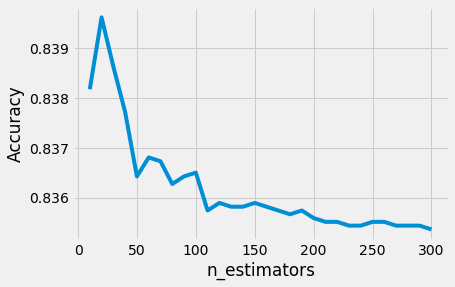

In [55]:
plt.plot(estimator_range, accuracy_scores)
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')

In [56]:
# show the best acuracy and the corresponding n_estimators
print("(Accuracy,Best n_estimators)",sorted(zip(accuracy_scores, estimator_range))[::-1][0])

(Accuracy,Best n_estimators) (0.8396183455552627, 20)


In [57]:
# list of values to try for max_features
feature_range = range(1, len(feature_cols)+1)
# list to store the average Accuracy for each value of max_features
accuracy_scores = []
# use 10-fold cross-validation with each value of max_features (WARNING: SLOW!)
for feature in feature_range:
    clf = RandomForestClassifier(n_estimators=200, max_features=feature, random_state=1, n_jobs=-1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=5, scoring='accuracy').mean())

Text(0,0.5,'Accuracy')

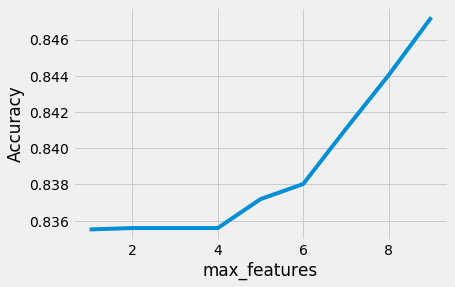

In [58]:
plt.plot(feature_range, accuracy_scores)
plt.xlabel('max_features')
plt.ylabel('Accuracy')

In [59]:
# show the best acuracy and the corresponding max_features
print("(Accuracy,Best max_features)",sorted(zip(accuracy_scores, feature_range))[::-1][0])

(Accuracy,Best max_features) (0.8472231112124715, 9)


In [60]:
# list of values to try for max_depth
max_depth_range = range(1, 50)
# list to store the average RMSE for each value of max_depth
accuracy_scores = []

# use 10-fold cross-validation with each value of max_depth
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

for depth in max_depth_range:
    clf = RandomForestClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X, y, cv=10, scoring='accuracy').mean())

Text(0,0.5,'Accuracy')

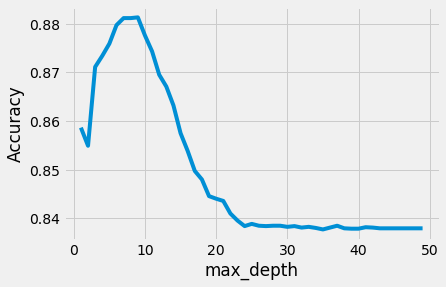

In [61]:
# plot max_depth (x-axis) versus RMSE (y-axis)
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('max_depth')
plt.ylabel('Accuracy')

In [62]:
# show the best acuracy and the corresponding max_depth
print("(Accuracy,Best max_depth)",sorted(zip(accuracy_scores, max_depth_range))[::-1][0])

(Accuracy,Best max_depth) (0.881293109097012, 9)


In [63]:
clf = RandomForestClassifier(max_depth=9,n_estimators=20,max_features=9,random_state=1, n_jobs=-1)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=9, max_features=9, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [64]:
# compute feature importances
pd.DataFrame({'feature':feature_cols, 'importance':clf.feature_importances_}).sort_values('importance')

,feature,importance
4,M_CamryBase,0.000039
3,M_Camry4dr,0.000504
7,M_CamrySE,0.003372
5,M_CamryL,0.004247
8,M_CamryXLE,0.010379
2,M_Camry,0.010591
6,M_CamryLE,0.018174
0,Year,0.141538
1,Mileage,0.811158


In [65]:
y_pred_rf = clf.predict(X_test)
y_pred_rf

array([1, 1, 1, ..., 1, 1, 0])

In [66]:
print("Accuracy RF Tuning:",metrics.accuracy_score(y_pred_rf, y_test))

Accuracy RF Tuning: 0.8758064516129033


In [67]:
#Ahora bagging 10 trees random forest

In [68]:
np.random.seed(123)
n_samples = X_train.shape[0]
n_B = 10
# create ten bootstrap samples (will be used to select rows from the DataFrame)
samples1 = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]

In [69]:
y_pred1 = pd.DataFrame(columns=["Sample","Accuracy"])
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_B)))

In [70]:
#Arbol con los mejores parametros
clf = RandomForestClassifier(max_depth=9,n_estimators=20,max_features=9,random_state=1, n_jobs=-1)

In [71]:
for i, sample in enumerate(samples1):
    X_train1 = X_train.iloc[sample]
    y_train1 = y_train.iloc[sample]
    clf.fit(X_train1, y_train1)
    y_pred_df.iloc[:, i] =clf.predict(X_test)
    y_pred1.at[i,"Sample"]=i
    y_pred1.at[i,"Accuracy"]=metrics.accuracy_score(y_pred_df.iloc[:, i], y_test)

In [72]:
y_pred_df.astype(int).head()

,0,1,2,3,4,5,6,7,8,9
332784,1,0,0,0,1,1,1,0,1,1
146436,1,1,1,1,1,1,1,1,1,1
130476,1,1,1,1,1,1,1,1,1,1
85618,1,1,1,1,1,1,1,1,1,1
75474,0,0,0,0,0,0,0,0,0,0


In [73]:
y_pred1

,Sample,Accuracy
0,0,0.870046
1,1,0.877419
2,2,0.871659
3,3,0.875576
4,4,0.870046
5,5,0.873963
6,6,0.873272
7,7,0.873502
8,8,0.870968
9,9,0.876267


In [74]:
y_pred1["Accuracy"].mean()

0.8732718894009217

In [75]:
y_pred = (y_pred_df.sum(axis=1) >= (n_B / 2)).astype(np.int)
print("Accuracy Bagging 10 samples:",metrics.accuracy_score(y_pred, y_test))

Accuracy Bagging 10 samples: 0.8785714285714286
